## Data management project data acquisition script

We first start by importing useful libraries. There is a blue comment due to an issue in the enchant library which can not be installed with the right dependencies on MacOs machines with Apple chips, and as such can be useful; more to look into this can be found here: https://github.com/pyenchant/pyenchant/issues/265

In [15]:
# remember to run export PYENCHANT_LIBRARY_PATH=/opt/homebrew/lib/libenchant-2.dylib before launching this notebook

from yahoo_fin.stock_info import get_day_gainers
from yahoo_fin.stock_info import get_day_losers
from yahoo_fin.stock_info import get_day_most_active
from yahoo_fin.stock_info import get_live_price
from yahoo_fin.stock_info import get_quote_table
# yahoo_fin is a scraper able to get various real-time financial data from https://finance.yahoo.com
import requests #useful for API connection
import praw #useful to create an APP with reddit
from textblob import TextBlob #useful to analyze sentiment
import re
import json
import nltk 
from nltk.corpus import words
import enchant
import pandas as pd
import numpy as np
import warnings
import time
from datetime import datetime
import pymongo
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi

We then now start our work by defining various useful custom-built functions:

In [16]:
def valid_ticker(ticker, tickerlist):
    if ticker in tickerlist:
        return True
    else:
        return False

This is a pretty straightforward function to just check if an item is in a specific list, and it is mainly used in other functions

In [17]:
def get_keys_from_value(dictionary, value):
    for key in dictionary.keys():
        if value in dictionary[key]:
            return key

This other function will be useful too multiple times throughout the notebook and just retrieves keys of any dict from its value. It should be noted, for reasons explained afterwards, that in general this function retrieves the value associated with the _first_ key that it founds within a dictionary. 

In [18]:
def is_english_word(input_str, exempt_list):
    if input_str in exempt_list:
        return False
    d = enchant.Dict("en_US")
    if d.check(input_str):
        return True
    return False

This function too appears really easy; its main job is just to check if a given string is a word of the english alphabet (more specifically, of the US language dictionary), but only proceeds in doing so if said string is not in an "exempt list" (list of strings). 

This is because in general we found two important behaviours: the first is that if we go looking for tickers in a reddit post's comments, body or title we might find text in caps lock as part of a sentence that is also a valid ticker; one such example is $LOVE. More often than not in this case "LOVE" is just part of a sentence and not a ticker, so all tickers that are also a valid word are risky choices to include and might pollute dataset: it is better to eliminate them. 

But if we were to eliminate all of them we would also risk losing many interesting information that might be present in reddit posts: stocks like $PLUG would be eliminated despite being popular among redditors. Hence the correction with the exempt list, that will be made of "interesting" stocks that are not to be eliminated despite having words as tickers.  

In [19]:
def analyze_sentiment(text):
    blob = TextBlob(text)
    sentiment_score = blob.sentiment.polarity
    return "Positive" if sentiment_score > 0 else "Negative" if sentiment_score < 0 else "Neutral"

This function too is fairly easy and just computes the sentiment of a given text, and will be used to assess sentiment of reddit posts.

In [20]:
def ticker_decider(text, valid_tickers, exempt_tickers):
    newtext=text.replace(",", "").replace(".", "").replace("$", "").replace(";", "").replace(":", "").replace("?", "").replace("!", "").replace("-", " ").replace("(", " ").replace(")", " ")
    words=newtext.split(' ')
    # text is now splitted into a list of words
    tickerlist={}
    for word in words:
        m=re.search('[A-Z]+$', word)
        if m :
            if word not in tickerlist.keys(): 
                if valid_ticker(word, valid_tickers):
                    tickerlist[word]=str(0) # here we set zero because then comes the next if which increments.
            if word in tickerlist.keys(): 
                tickerlist[word]=str(int(tickerlist[word])+1)
            # we are using strings and not ints for convenience.
    values=list(tickerlist.values())
    # we now have a ticker list as a dictionary. If empty:
    if values==[]:
        return {}
    
    while tickerlist!={}:
        if len(tickerlist)==1:
            max_occurrence=max(int(i) for i in values)
            ticker=get_keys_from_value(tickerlist, str(max_occurrence))
            if max_occurrence==1: 
                if is_english_word(ticker, exempt_tickers):
                    return {}
            return {ticker: max_occurrence}
        max_occurrence=max(int(i) for i in list(tickerlist.values()))
        ticker=get_keys_from_value(tickerlist, str(max_occurrence))
        if len(ticker)!=1:
            if max_occurrence==1:
                if is_english_word(ticker, exempt_tickers)!=True:
                    return {ticker: max_occurrence}
                else:
                    return {}
        if max_occurrence==1 & len(tickerlist)!=1:
            del tickerlist[ticker]
        else:
            return {ticker: max_occurrence}

This is the single most important function, and the more complex one. It should independently decide, given an input text, a list of valid tickers and a list of tickers to be considered valid even if words, which is the ticker to be associated with that text. 

The rationale of this function is as follows: usually tickers are found among text as a string of uppercase letters. One could also try and check if every word is a name of a company but usually this is not specific enough; take Meta, for example: one could talk about Meta by saying "META" (ticker), Facebook, Meta, Meta Platforms, Meta Platforms Inc., Zuck's company, Instagram, Whatsapp, etc.

As such text referring to a company can be aleatory and not reliable; instead usually looking for tickers can be productive since they are easy to spot and widely used throughout walstreetbets. Clearly this is not a foolprof method but the hope is that the ticker is mentioned at least once between title, body, comments. 

Note that via this way we will lose some posts that might've contained important information: such as those where maybe information was conveyed via an image or a video, but alternate solutions to extract a ticker from a post that would keep track of everything were way too complex, slow and/or needed resource and expertise beyond the scope of the project (such as developing a machine learning classification model able to get as input text, video, images, or other techniques). 

Because of this, the first thing our function does is to split all the text, that will be a blob of title, body and comments, in different strings, one for each word; during this process we can also do a little bit of cleanup: when we encounter a ticker, it might have the $ symbol before it, or it might have accents or other punctuation; clearly we want to get rid of this so it's best to replace it either with a blank space or with nothing. 

Then comes the problem of how to choose what ticker a specific post is about: say the post started as an AAPL post, but in the comments effectively people talked about NVIDIA. Then we sould assign to that post NVIDIA, not AAPL; to overcome this we can simply count how many times we found each ticker, and choose the one found the most. 

So, for every word in word in our word list created splitting the overall text, we first check that indeed it's in the form of a ticker (string of uppercase letters). Then, we check if we already have it in our dictionary of tickers and how many times they were found. If we do, then we just increase the number of times we found it. If not instead, we first check that it is actually a valid ticker, using the valid_ticker function; we then create a new entry in our dict with that possible ticker and increase the number of times to 1. 

We are now in possess of a dictionary with valid tickers and the times we found them, but this is not enough. First of all if the dictionary is empty, we just return an empty dict and that's it. Else, we now have to still check if the various entries in our ticker list make sense: they might be english words in uppercase letters that were part of a sentence (recall LOVE, from the is_english_word function), or they might just be like random one-letter uppercase string, generated by the uppercase at the start of a sentence (think of a sentence starting with I, A, or similar; those are valid tickers indeed, sadly). 

One way to deal with these annoying singl-digit tickers that generally pollute the data quite a lot, is to consider, if existing, the first non-single-digit ticker found: let's say I found A with frequency 2 and NVIDIA with frequency 2. Then it's most likely the post was talking about NVIDIA and not Agilent technologies, so we choose to return a dict containing {NVIDIA; 2}. 

Now we should be careful still since some single-digit tickers are still interesting; think of how polarizing X (formerly Twitter) is! To deal with cases such as this we hope that the ticker pops up multiple times throughout the text, and/or is the only one to pop up. If that's the case, then we keep the single-digit ticker. 

In both these scenario one last check is needed, that is, to check that the "ticker" found is not an english word, but an "interesting" ticker or just a ticker not resembling english words.

The algorithm is as follows: we start checking that our tickerlist is not empty. 

Then, if our tickerlist only has one entry, we check how many times we found the ticker. If we only found it one time, we check if it's an english word and if it is we discard it; if not, we return it. If at last we found it mutiple times (>1) we assume it not to be a coincidence and we return it without checking its validity as a word. 

If instead our tickerlist has more than one entry, things get more complicated: we first establish which ticker was found the most times. If this ticker is not single-digit, we check how many times it was found; if it's greater than one we return it, assuming that it is not a coincidence and it is not an english word in any case. Otherwise if it was found one time we check if it indeed is an english word or not; if it is not, we return it. If it is an english word, we discard it instead and return an empty dict. 

At last if our ticker is single-digit, if we found it more than once we return it assuming it not to be a coincidence, else if we found and we have some other ticker in the list we just delete it and proceed to restart the whole thing. All of this can be particularly complex, so a schema is present down below:

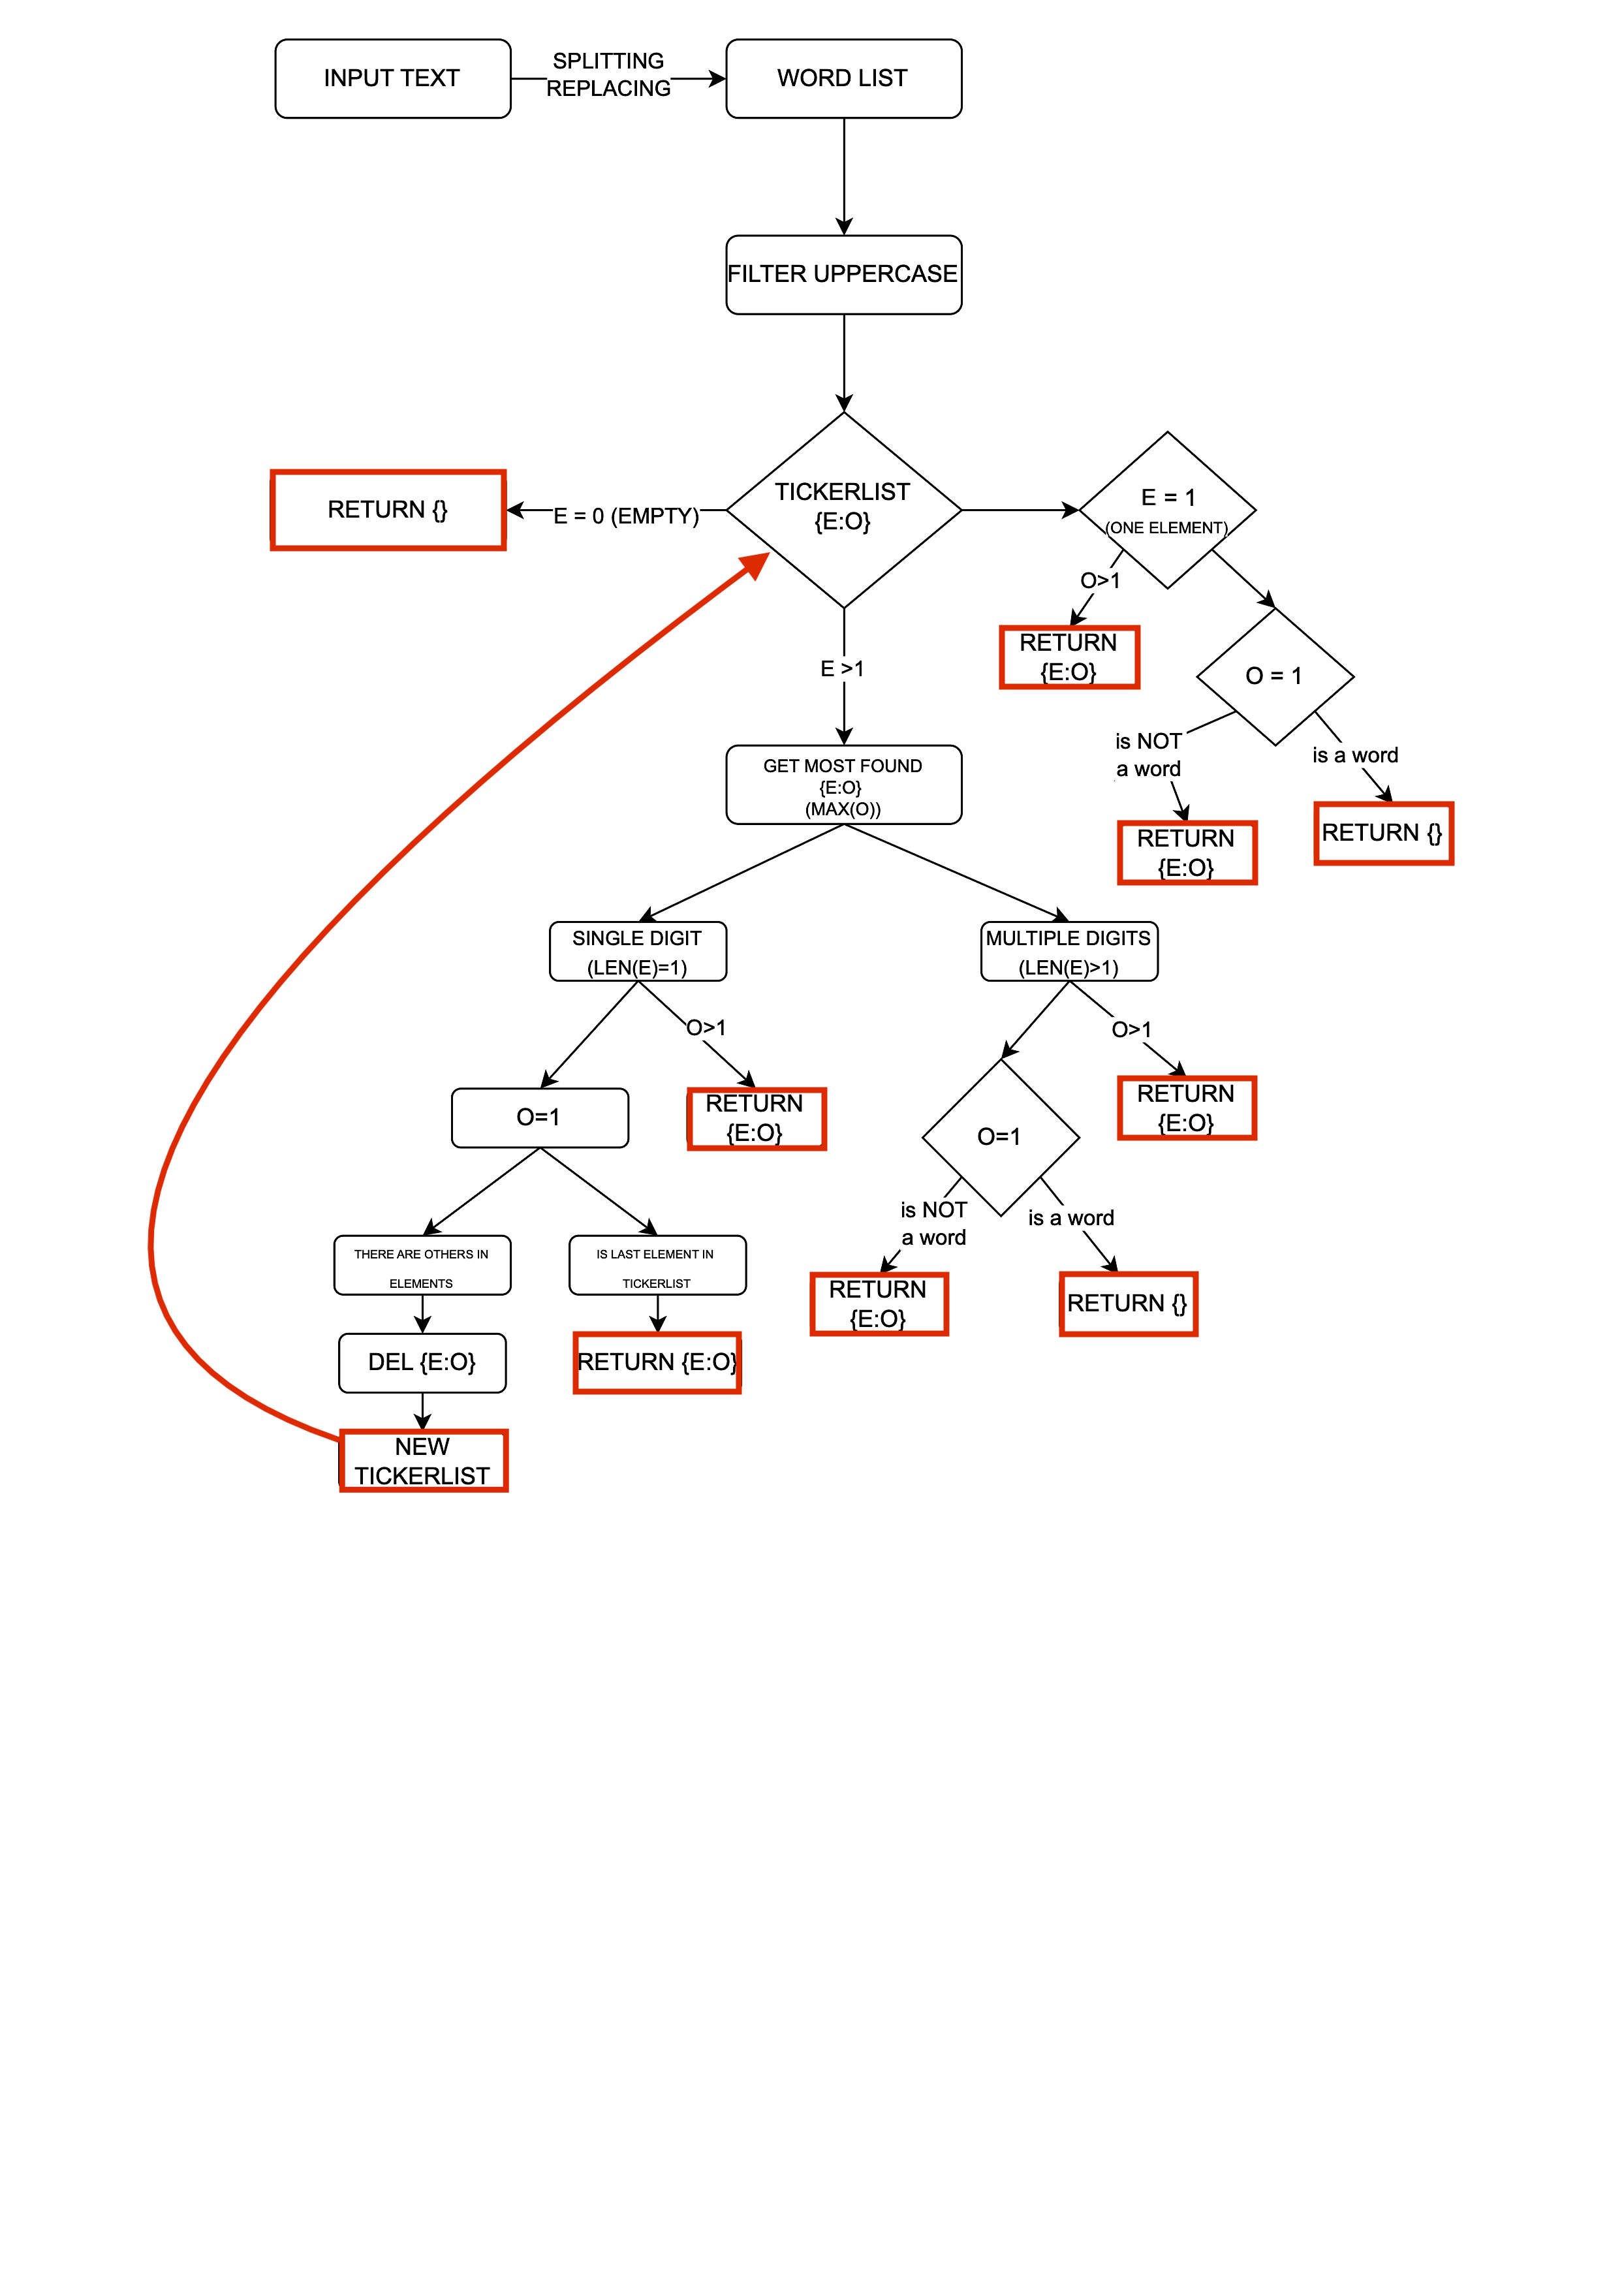

In the schema above, Element is any ticker and Occurrence is the number of times it was found.

While this algorithm does its job fairly well, it can be improved upon in many ways - this is explored better in the report and in the cleaning_integration_script.

In [21]:
def find_ticker (submission_title, submission_selftext, submission_comment, tickerlist, submission, exempt_tickers):
    i=0
    submission.comments.replace_more(limit=0) # this loads all comments instances 
    submission.comment_sort='top' # sorting comments on upvotes
    commentslist='' 
    while i<len(submission_comment):
        if submission.num_comments/(submission.score+submission.num_comments) < 0.5: 
            if submission_comment[i].score<0.04*submission.score:
                i+=1
            else:
                commentslist=commentslist+' '+(submission_comment[i]).body
                i+=1
        else:
            commentslist=commentslist+(submission_comment[i]).body
            i+=1
            if i>50:
                i=len(submission_comment)
    final_text=submission_title+' '+submission_selftext+' '+commentslist
    return ticker_decider(final_text, tickerlist, exempt_tickers)

The last function needed is the find_ticker function. It basically just decides which text should be kept and fed into ticker_decider, and returns whatever ticker_decider thinks of that text. 

The main problem with this is that while title and body of a post are clearly interesting informations and can be kept, the number of comments to be kept is not that straightforward: we can not consider thousands upon thousands of comments under popular posts because either we would get disconnected from the reddit APP because of too many requests or we would have computational times longer than manageable. 

The idea behind the number of comments to choose is the following: in general, any post with lots of upvotes that will be popular will generate a lot of comments. But some posts, when controversial, can have low upvotes and high comments thanks to the upvote-downvote mechanism of reddit. Moreover there will also be posts low in both comments and upvotes and at last post with many comments and little upvotes. Lastly, we have to keep in mind comments themselves have upvotes too, and we can exploit that.

We first define the fraction number of $\frac{\#comments}{(upvotes + \#comments)}$; this helps us navigate which case we find ourselves into for each post: if # of comments is high with respect to upvotes, then we expect that fraction to be closer to one. This usually means low upvotes and high comments, as such post will be controversial and it is worth keeping the first 50 most upvoted comments as representative. 

If instead that fraction is low, this means little comments and/or higher upvotes, and as such we can just take all the comments with a number of upvotes that is over a specific fraction of the post's upvotes.

In our case we considered an "high" number of comments when the fraction was above 0.5 and low number of comments vice versa, and we set as threshold for the upvotes in comments a 0.4 (meaning that when upvotes were high we only kept comments that had 40% of the post's upvotes or more). 

At last we bind title, body and comments together and we feed it to ticker decider.

At last we can now proceed and setup everything:

In [22]:
url = #insert your MongoDb connections details here
client = MongoClient(url, server_api=ServerApi('1'))
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


In [24]:
db=#insert your MongoDb Database details here
reddit = praw.Reddit(
    client_id=#insert your Reddit id details here
    client_secret=#insert your Reddit Client_secret details here,
    user_agent=#insert your Reddit User Agent details here
)
subreddit = reddit.subreddit('Wallstreetbets')
#For more details check out either Praw documentation or PyMongo documentation.
#From now on we expect two distinct collections in the MongoDB database: a YahooData one and a RedditPosts one.

Now we have connection of both MongoDB and Reddit APP

In [13]:
f = open('company_tickers.json', 'r')
jsontickers=json.load(f)
tickerlist=[]
for i in range(len(jsontickers)):
    index=str(i)
    tickerlist.append(jsontickers[index]['ticker'])
tickerlist.remove('AI') #Artificial Intelligence
tickerlist.remove('DD') #Dude Diligence
tickerlist.remove('OP') #Original Person
tickerlist.remove('TD') #Broker name
tickerlist.remove('IBKR') #Same as TD
tickerlist.remove('GL') #Good Luck
tickerlist.remove('IT') #Information technology
tickerlist.remove('EU') #European Union
tickerlist.remove('TV') #Television

Here instead we are creating a list of valid tickers, starting from a comprehensive list of all tickers in US markets from the SEC (source: https://www.sec.gov/file/company-tickers). We then remove some ticker that albeit valid are likely to generate noise due the fact that they represent some popular abbreviation of words.

In [ ]:
now=datetime.now()
print('starting at ', now.time())
warnings.filterwarnings("ignore")
acquisitions=0
total_acquisitions=78
while acquisitions!=total_acquisitions:
    print(acquisitions)
    start = time.time()
    
    # we start by acquiring "gainers", "losers" and "active" stocks data; then we organize it into a table with
    # respect to their volume, the measure of activity, and we create two binary attributes (is gainer and 
    # is loser) to keep track of everything. At last we insert a live price attribute where we store prices. 
    
    gainers_df=get_day_gainers()
    losers_df=get_day_losers()
    active_df=get_day_most_active()
    total_df=pd.concat([gainers_df, active_df, losers_df])
    total_df.sort_values('Volume', ascending=False, inplace=True)
    total_df.drop_duplicates('Name', inplace=True)
    total_df.reset_index(inplace=True)
    total_df.drop(axis=1, columns='index', inplace=True)
    total_df['is_gainer']=0
    total_df['is_loser']=0
    total_df['live_price']=0
    actual_time=datetime.now()
    total_df['acquisition_time']=actual_time
    for i in range(len(total_df)):
        if total_df['Symbol'][i] in gainers_df['Symbol'].unique():
            total_df['is_gainer'][i]=1
        else:
            if total_df['Symbol'][i] in losers_df['Symbol'].unique():
                total_df['is_loser'][i]=1
        total_df['live_price'][i]=round(get_live_price(total_df['Symbol'][i]), 2)
        
    # we then upload everything on the database.
    
    collection=db['YahooData']
    result = collection.insert_many(total_df.to_dict('records'))
    print('yahoo done')
    
    # If we are at the first acquisition or after 3 or 6 hours we also acquire reddit data
    
    if acquisitions%36==0:  
        reddit_predf={}
        tickerlist_from_yahoo=total_df['Symbol'].unique()
        authors, titles, sentiments, comments_nums, upvotes, tickers_total=[],[],[],[],[], []
        i=0
        
        # we only consider the top 50 (by upvotes) posts of the day for computational time reasons, mostly.
        # per each post we collect Title, Author, Upvotes, Sentiment, comments number, time and ticker data.
        
        for post in subreddit.top(time_filter='day'):
            tickers = find_ticker(post.title, post.selftext, post.comments, tickerlist, post, tickerlist_from_yahoo)
            if tickers!={}:
                authors.append(post.author.name if post.author else np.NaN)
                titles.append(post.title)
                sentiments.append(analyze_sentiment(post.title))
                comments_nums.append(post.num_comments)
                upvotes.append(post.score)
                tickers_total.append(tickers)
                i+=1
            if i==50:
                break
        reddit_predf['author']= authors
        reddit_predf['title']=titles    
        reddit_predf['sentiment']=sentiments       
        reddit_predf['comments_num']=comments_nums
        reddit_predf['upvotes']=upvotes       
        reddit_predf['Symbol']=tickers_total
        reddit_predf['acquisition_time']=actual_time
        reddit_df=pd.DataFrame(reddit_predf)
        reddit_df['ticker_found_times']=0
        for i in range(len(reddit_df)):
            a=list(set(reddit_df['Symbol'][i].values()))
            b=list(set(reddit_df['Symbol'][i].keys()))
            reddit_df['ticker_found_times'][i]=a[0]
            reddit_df['Symbol'][i]=b[0]
        collection=db['RedditPosts']
        result = collection.insert_many(reddit_df.to_dict('records'))
        print('reddit done')
    acquisitions+=1
    end = time.time()
    print(end-start)
    print('now sleeping for ', max(0, 300-(end-start)))
    time.sleep(max(0, 300-(end-start)))
now=datetime.now()
print('ended at ', now.time())

This is the actual acquisition script. It is to be run at market open and will automatically last till the closure of the day, acquiring yahoo finance real time data every 5 minutes and reddit posts every 3 hours, for a total of 78 and 3 acquisitions respectively. 

There is one thing to be noted here. One might recall that in defining the is_english_word function, later used in ticker_decider, we had a list of tickers to be exempt of the examination, "interesting" tickers. Clearly this is case dependent; we chose to enhance the possible bridging between the reddit post dataset and yahoo financial data's dataset and basically we pulled a list of unique tickers from the yahoo acquisition. If a ticker was already there we considered it valid despite it possibly being also an english word. To follow above-used examples, if $PLUG was a gainer, loser or just active stock of the day it would be present in the exempt list and as such it would still be conserved and its data gathered, since is_english_word would return False, on the idea that albeit it is an english word it is not to be discarded because of this.


In [28]:
# we now can create two new collections in which we can copy all the acquired data such that every cleaning
# or enriching activity is performed there and if something goes south we can recover data and restart. 

collection1=db['YahooData']
collection2=db['RedditPosts']

data_collection1 = list(collection1.find())
data_collection2 = list(collection2.find())

# unblock following if you want to donwload said data
#with open('yahoo_data.json', 'w') as file:
#    json.dump(data_collection1, file, default=str)
#with open('reddit_data.json', 'w') as file:
#a    json.dump(data_collection2, file, default=str)

In [29]:
db.create_collection('YahooData_towork')
db.create_collection('RedditPosts_towork')

Collection(Database(MongoClient(host=['ac-ztp8o8e-shard-00-00.ogt87ap.mongodb.net:27017', 'ac-ztp8o8e-shard-00-02.ogt87ap.mongodb.net:27017', 'ac-ztp8o8e-shard-00-01.ogt87ap.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, retrywrites=True, w='majority', authsource='admin', replicaset='atlas-x6kwbo-shard-0', ssl=True, server_api=<pymongo.server_api.ServerApi object at 0x15fea88e0>), 'RedditXFinance'), 'RedditPosts_towork')

In [30]:
collection3=db['YahooData_towork']
collection4=db['RedditPosts_towork']
collection3.insert_many(data_collection1)
collection4.insert_many(data_collection2)